In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import json
import datetime
from scipy.stats import linregress

# Import API key
from config import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [2]:
# Define a function that creates a set of "n" random lat and lng combinations
def city_set(n):
    
    lats = np.random.uniform(lat_range[0], lat_range[1], size=n)
    lngs = np.random.uniform(lng_range[0], lng_range[1], size=n)
    return zip(lats, lngs)

In [5]:
# Request weather data (temperature, humidity, cloudiness, windspeed) from OpenWeather

attempted = []
cities = []
lat = []
lng = []
temp = []
humidity = []
cloudiness = []
windspeed = []
country = []
date = []

print("-----------------------------------")
print("Retrieving Data – Please be patient")
print("-----------------------------------")


while len(cities) < 500:
    
    sample = city_set(10)
    for coord in sample:
        
        city = citipy.nearest_city(coord[0], coord[1]).city_name
        
        if city in attempted:
            break
        
        elif city not in cities:
            
            # Avoid exceeding 60 calls per minute from API request
            time.sleep(1)
            
            # Request data from API
            city_url = "http://api.openweathermap.org/data/2.5/weather?q=" \
                + city + "&appid=" + weather_api_key + "&units=imperial"
            response = requests.get(city_url).json()
            
            try:
                lat.append(response["coord"]["lat"])
                lng.append(response["coord"]["lon"])
                temp.append(response["main"]["temp_max"])
                humidity.append(response["main"]["humidity"])
                cloudiness.append(response["clouds"]["all"])
                windspeed.append(response["wind"]["speed"])
                country.append(response["sys"]["country"])
                date.append(response["dt"])
                cities.append(city)
                print(f"Found data for city #{len(cities)}: {city}")
                
            except:
                print(f"City '{city}' not found. Proceeding to next city.")
                pass
            
            attempted.append(city)
    
print("-------------------------------------------")
print(f"Successfully retrieved data for {len(cities)} cities.")
print("-------------------------------------------")

-----------------------------------
Retrieving Data – Please be patient
-----------------------------------
Found data for city #1: ornskoldsvik
Found data for city #2: longyearbyen
City 'taolanaro' not found. Proceeding to next city.
Found data for city #3: labuhan
Found data for city #4: iqaluit
Found data for city #5: hobart
Found data for city #6: albany
Found data for city #7: goksun
Found data for city #8: carnarvon
Found data for city #9: busselton
Found data for city #10: berlevag
Found data for city #11: tiksi
Found data for city #12: bhadrachalam
Found data for city #13: bonavista
Found data for city #14: kayerkan
City 'kawana waters' not found. Proceeding to next city.
Found data for city #15: morondava
Found data for city #16: santa cecilia
Found data for city #17: jamestown
Found data for city #18: panzhihua
Found data for city #19: lorengau
Found data for city #20: te anau
Found data for city #21: cidreira
Found data for city #22: bluff
Found data for city #23: saint-pier

Found data for city #204: makakilo city
Found data for city #205: bambous virieux
Found data for city #206: anloga
Found data for city #207: tallahassee
Found data for city #208: coquimbo
Found data for city #209: kavieng
Found data for city #210: isetskoye
Found data for city #211: dicabisagan
City 'vastervik' not found. Proceeding to next city.
Found data for city #212: kozhva
Found data for city #213: sawtell
Found data for city #214: fortuna
City 'toliary' not found. Proceeding to next city.
Found data for city #215: auki
Found data for city #216: dondo
Found data for city #217: mesetas
Found data for city #218: sakakah
Found data for city #219: ostrovnoy
City 'grand river south east' not found. Proceeding to next city.
Found data for city #220: esperance
Found data for city #221: chapais
Found data for city #222: ixtapa
Found data for city #223: rio grande
Found data for city #224: mareeba
Found data for city #225: ihosy
Found data for city #226: vao
City 'metehara' not found. Pro

Found data for city #411: acton vale
Found data for city #412: formosa
Found data for city #413: blieskastel
Found data for city #414: nikolskoye
Found data for city #415: prince rupert
Found data for city #416: wichita falls
Found data for city #417: moron
Found data for city #418: bilibino
Found data for city #419: rawalpindi
Found data for city #420: koungou
Found data for city #421: nago
Found data for city #422: yeppoon
Found data for city #423: bull savanna
Found data for city #424: tibati
Found data for city #425: imbituba
Found data for city #426: yanam
Found data for city #427: aykhal
City 'hunza' not found. Proceeding to next city.
Found data for city #428: baoshan
Found data for city #429: bayji
Found data for city #430: ruthin
Found data for city #431: ust-maya
City 'kerteh' not found. Proceeding to next city.
Found data for city #432: san quintin
Found data for city #433: graaff-reinet
Found data for city #434: damaturu
Found data for city #435: okhotsk
Found data for city

In [6]:
# Create a dataframe
weather_df = pd.DataFrame({
    "City":cities,
    "Latitude":lat,
    "Longitude":lng,
    "Max Temperature (°F)":temp,
    "Humidity (%)":humidity,
    "Cloudiness (%)":cloudiness,
    "Wind Speed (mph)":windspeed,
    "Country Code":country,
    "Date & Time":date
})

# Extract average timestamp & store for later
mean_date = weather_df["Date & Time"].mean()
retrieval_date = datetime.datetime.fromtimestamp(mean_date).date()

# Export data into a csv
weather_df.to_csv(output_data_file,index = False)


weather_df.head()

,City,Latitude,Longitude,Max Temperature (°F),Humidity (%),Cloudiness (%),Wind Speed (mph),Country Code,Date & Time
0,ornskoldsvik,63.2909,18.7153,10.40,92,0,8.05,SE,1612824056
1,longyearbyen,78.2186,15.6401,14.00,52,0,10.36,SJ,1612824065
2,labuhan,-6.8844,112.2051,77.81,86,92,7.40,ID,1612824071
3,iqaluit,63.7506,-68.5145,21.20,86,75,4.50,CA,1612824072
4,hobart,-42.8794,147.3294,57.99,54,75,11.50,AU,1612823997


## Scatterplots

This scatterplot shows the relationship between Temperature and Latitude of each city.

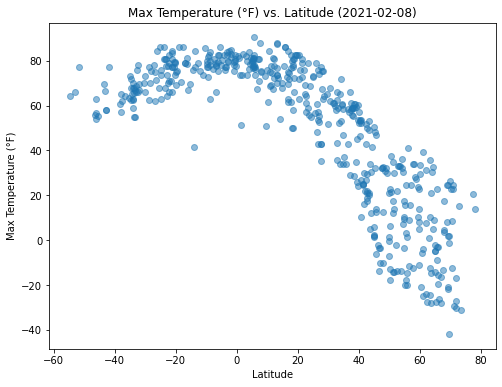

In [7]:
x_values = weather_df["Latitude"]
y_str = "Max Temperature (°F)"
y_values = weather_df[y_str]

plt.figure(figsize=(8,6))
plt.scatter(x_values, y_values,alpha=0.5)
plt.title(f'{y_str} vs. Latitude ({retrieval_date})')
plt.xlabel("Latitude")
plt.ylabel(y_str)

plt.savefig("output_data/Temperature_vs_Latitude.png")
plt.show()

This scatterplot shows the relationship between Humidity and Latitude of each city.

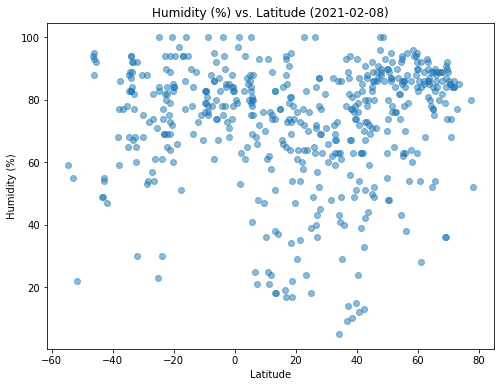

In [8]:
x_values = weather_df["Latitude"]
y_str = "Humidity (%)"
y_values = weather_df[y_str]

plt.figure(figsize=(8,6))
plt.scatter(x_values, y_values,alpha=0.5)
plt.title(f'{y_str} vs. Latitude ({retrieval_date})')
plt.xlabel("Latitude")
plt.ylabel(y_str)

plt.savefig("output_data/Humidity_vs_Latitude.png")
plt.show()

This scatterplot shows the relationship between Cloudiness and Latitude of each city.

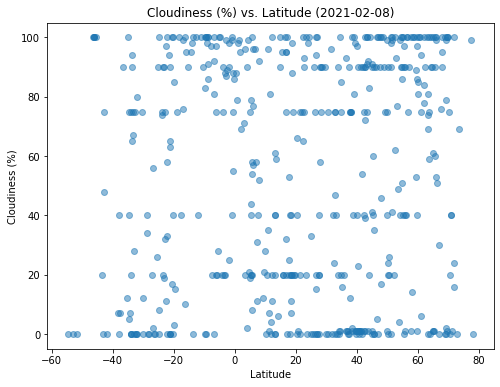

In [9]:
x_values = weather_df["Latitude"]
y_str = "Cloudiness (%)"
y_values = weather_df[y_str]

plt.figure(figsize=(8,6))
plt.scatter(x_values, y_values,alpha=0.5)
plt.title(f'{y_str} vs. Latitude ({retrieval_date})')
plt.xlabel("Latitude")
plt.ylabel(y_str)

plt.savefig("output_data/Cloudiness_vs_Latitude.png")
plt.show()

This scatterplot shows the relationship between Wind Speed and Latitude of each city.

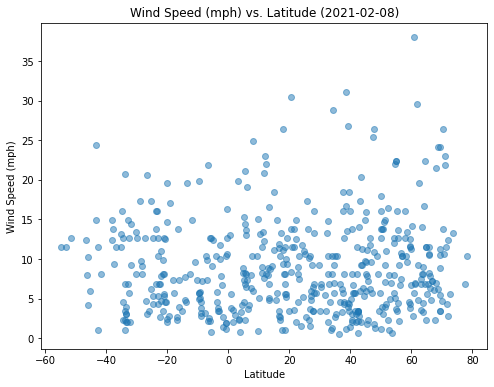

In [10]:
x_values = weather_df["Latitude"]
y_str = "Wind Speed (mph)"
y_values = weather_df[y_str]

plt.figure(figsize=(8,6))
plt.scatter(x_values, y_values,alpha=0.5)
plt.title(f'{y_str} vs. Latitude ({retrieval_date})')
plt.xlabel("Latitude")
plt.ylabel(y_str)

plt.savefig("output_data/Wind_Speed_vs_Latitude.png")
plt.show()

## Linear Regression

To analyze each relationship using linear regression, we will separate the data by hemisphere (since we are exploring whether distance away from the equator, where latitude is zero, is correlated with the weather data).

In [11]:
# Create a DataFrame for each hemisphere

north_df = weather_df.loc[weather_df["Latitude"]>=0]

south_df = weather_df.loc[weather_df["Latitude"]<0]

#### Northern Hemisphere: Temperature vs. Latitude

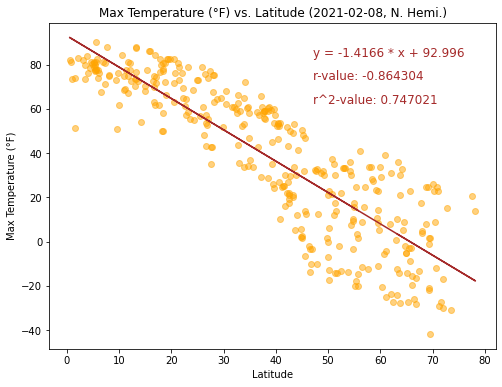

In [12]:
x_values = north_df["Latitude"]
y_str = "Max Temperature (°F)"
y_values = north_df[y_str]

plt.figure(figsize=(8,6))
plt.scatter(x_values, y_values,alpha=0.5,c="orange")
plt.title(f'{y_str} vs. Latitude ({retrieval_date}, N. Hemi.)')
plt.xlabel("Latitude")
plt.ylabel(y_str)

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = slope * x_values + intercept
plt.plot(x_values, regress_values,color="brown")

x = max(x_values)-.4*(max(x_values)-min(x_values))
y_range = (max(y_values)- min(y_values))
                      
plt.text(x,max(y_values)-y_range*.05,f"y = {round(slope,4)} * x + {round(intercept,4)}",c="brown",size=12)
plt.text(x,max(y_values)-y_range*.13,f"r-value: {round(rvalue,6)}",c="brown",size=12)
plt.text(x,max(y_values)-y_range*.21,f"r^2-value: {round(rvalue**2,6)}",c="brown",size=12)

plt.savefig("output_data/Temperature_vs_Latitude_North.png")
plt.show()

#### Southern Hemisphere: Temperature vs. Latitude

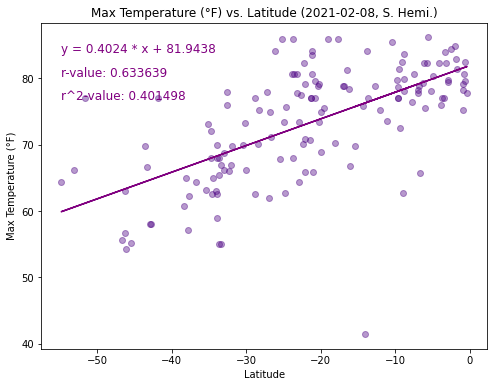

In [13]:
x_values = south_df["Latitude"]
y_str = "Max Temperature (°F)"
y_values = south_df[y_str]

plt.figure(figsize=(8,6))
plt.scatter(x_values, y_values,alpha=0.4,c="indigo")
plt.title(f'{y_str} vs. Latitude ({retrieval_date}, S. Hemi.)')
plt.xlabel("Latitude")
plt.ylabel(y_str)

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = slope * x_values + intercept
plt.plot(x_values, regress_values,color="purple")

x = min(x_values)
y_range = (max(y_values)- min(y_values))

plt.text(x,max(y_values)-y_range*.05,f"y = {round(slope,4)} * x + {round(intercept,4)}",c="purple",size=12)
plt.text(x,max(y_values)-y_range*.13,f"r-value: {round(rvalue,6)}",c="purple",size=12)
plt.text(x,max(y_values)-y_range*.21,f"r^2-value: {round(rvalue**2,6)}",c="purple",size=12)

plt.savefig("output_data/Temperature_vs_Latitude_South.png")
plt.show()

These scatterplots both have some level of medium to strong correlation (although it seems the North Hemisphere has a higher correlation), but clearly there are other factors than just latitude that influence temperature. A negative correlation in the Northern Hemisphere data would indicate that as latitude increases, temperature decreases. A positive correlation in the Southern Hemisphere data would indicate that as latitude increases, temperature also increases. We also know that the Earth's axis is tilted, so if we ran these results from a different season we may see these correlations get stronger/weaker in one hemisphere or the other (perhaps, inversely).

#### Northen Hemisphere: Humidity vs. Latitude

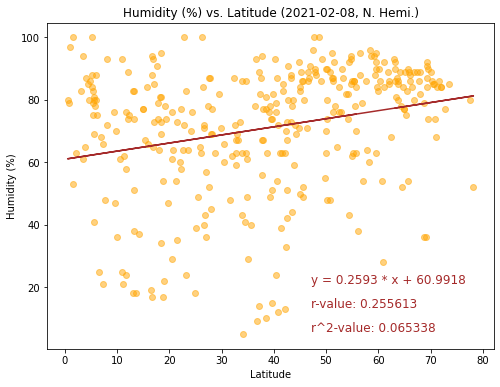

In [14]:
x_values = north_df["Latitude"]
y_str = "Humidity (%)"
y_values = north_df[y_str]

plt.figure(figsize=(8,6))
plt.scatter(x_values, y_values,alpha=0.5,c="orange")
plt.title(f'{y_str} vs. Latitude ({retrieval_date}, N. Hemi.)')
plt.xlabel("Latitude")
plt.ylabel(y_str)

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = slope * x_values + intercept
plt.plot(x_values, regress_values,color="brown")

x = max(x_values)-.4*(max(x_values)-min(x_values))
y_range = (max(y_values)- min(y_values))
                      
plt.text(x,min(y_values)+y_range*.17,f"y = {round(slope,4)} * x + {round(intercept,4)}",c="brown",size=12)
plt.text(x,min(y_values)+y_range*.09,f"r-value: {round(rvalue,6)}",c="brown",size=12)
plt.text(x,min(y_values)+y_range*.01,f"r^2-value: {round(rvalue**2,6)}",c="brown",size=12)

plt.savefig("output_data/Humidity_vs_Latitude_North.png")
plt.show()

#### Southern Hemisphere: Humidity vs. Latitude

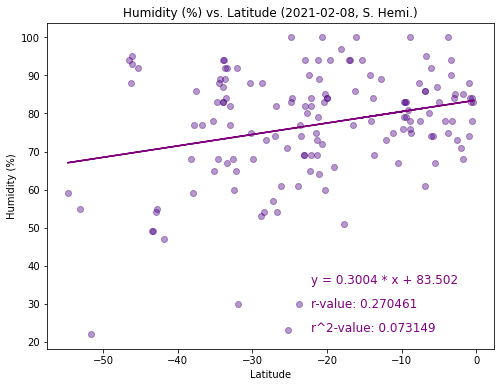

In [15]:
x_values = south_df["Latitude"]
y_str = "Humidity (%)"
y_values = south_df[y_str]

plt.figure(figsize=(8,6))
plt.scatter(x_values, y_values,alpha=0.4,c="indigo")
plt.title(f'{y_str} vs. Latitude ({retrieval_date}, S. Hemi.)')
plt.xlabel("Latitude")
plt.ylabel(y_str)

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = slope * x_values + intercept
plt.plot(x_values, regress_values,color="purple")

x = max(x_values)-.4*(max(x_values)-min(x_values))
y_range = (max(y_values)- min(y_values))

plt.text(x,min(y_values)+y_range*.17,f"y = {round(slope,4)} * x + {round(intercept,4)}",c="purple",size=12)
plt.text(x,min(y_values)+y_range*.09,f"r-value: {round(rvalue,6)}",c="purple",size=12)
plt.text(x,min(y_values)+y_range*.01,f"r^2-value: {round(rvalue**2,6)}",c="purple",size=12)

plt.savefig("output_data/Humidity_vs_Latitude_South.png")
plt.show()

While these graphs may show very weak correlations, they are too weak to draw many conclusions from. It would appear that humidity depends on either a variety of factors, or simply not latitude.

#### Northern Hemisphere: Cloudiness vs. Latitude

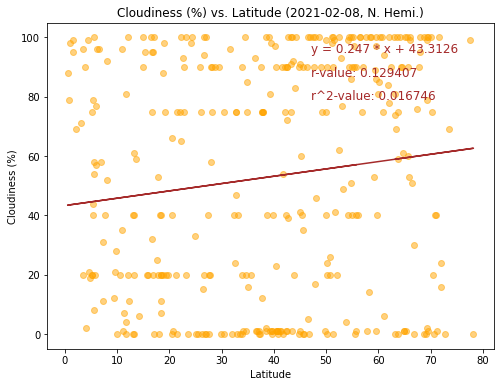

In [16]:
x_values = north_df["Latitude"]
y_str = "Cloudiness (%)"
y_values = north_df[y_str]

plt.figure(figsize=(8,6))
plt.scatter(x_values, y_values,alpha=0.5,c="orange")
plt.title(f'{y_str} vs. Latitude ({retrieval_date}, N. Hemi.)')
plt.xlabel("Latitude")
plt.ylabel(y_str)

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = slope * x_values + intercept
plt.plot(x_values, regress_values,color="brown")

x = max(x_values)-.4*(max(x_values)-min(x_values))
y_range = (max(y_values)- min(y_values))
                      
plt.text(x,max(y_values)-y_range*.05,f"y = {round(slope,4)} * x + {round(intercept,4)}",c="brown",size=12)
plt.text(x,max(y_values)-y_range*.13,f"r-value: {round(rvalue,6)}",c="brown",size=12)
plt.text(x,max(y_values)-y_range*.21,f"r^2-value: {round(rvalue**2,6)}",c="brown",size=12)

plt.savefig("output_data/Cloudiness_vs_Latitude_North.png")
plt.show()

#### Southern Hemisphere: Cloudiness vs. Latitude

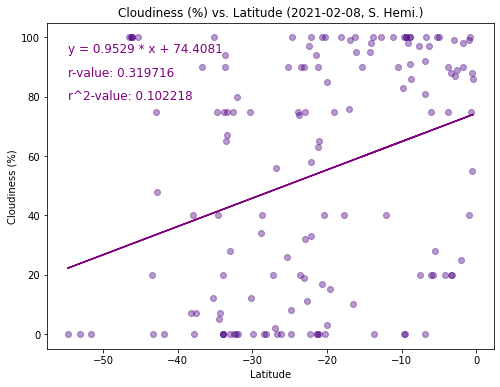

In [17]:
x_values = south_df["Latitude"]
y_str = "Cloudiness (%)"
y_values = south_df[y_str]

plt.figure(figsize=(8,6))
plt.scatter(x_values, y_values,alpha=0.4,c="indigo")
plt.title(f'{y_str} vs. Latitude ({retrieval_date}, S. Hemi.)')
plt.xlabel("Latitude")
plt.ylabel(y_str)

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = slope * x_values + intercept
plt.plot(x_values, regress_values,color="purple")

x = min(x_values)
y_range = (max(y_values)- min(y_values))

plt.text(x,max(y_values)-y_range*.05,f"y = {round(slope,4)} * x + {round(intercept,4)}",c="purple",size=12)
plt.text(x,max(y_values)-y_range*.13,f"r-value: {round(rvalue,6)}",c="purple",size=12)
plt.text(x,max(y_values)-y_range*.21,f"r^2-value: {round(rvalue**2,6)}",c="purple",size=12)

plt.savefig("output_data/Cloudiness_vs_Latitude_South.png")
plt.show()

These graphs also show very weak correlations between cloudiness and latitude, and we may not conclude that latitude has any impact on cloudiness that we can determine.

#### Northern Hemisphere: Wind Speed vs. Latitude

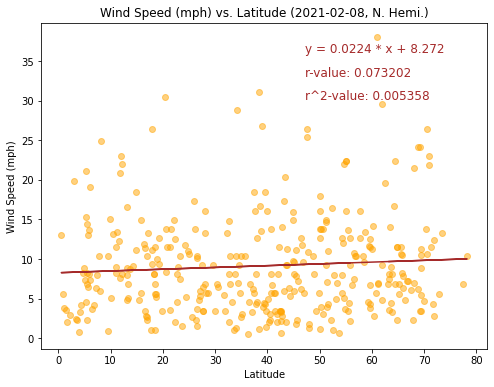

In [18]:
x_values = north_df["Latitude"]
y_str = "Wind Speed (mph)"
y_values = north_df[y_str]

plt.figure(figsize=(8,6))
plt.scatter(x_values, y_values,alpha=0.5,c="orange")
plt.title(f'{y_str} vs. Latitude ({retrieval_date}, N. Hemi.)')
plt.xlabel("Latitude")
plt.ylabel(y_str)

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = slope * x_values + intercept
plt.plot(x_values, regress_values,color="brown")

x = max(x_values)-.4*(max(x_values)-min(x_values))
y_range = (max(y_values)- min(y_values))
                      
plt.text(x,max(y_values)-y_range*.05,f"y = {round(slope,4)} * x + {round(intercept,4)}",c="brown",size=12)
plt.text(x,max(y_values)-y_range*.13,f"r-value: {round(rvalue,6)}",c="brown",size=12)
plt.text(x,max(y_values)-y_range*.21,f"r^2-value: {round(rvalue**2,6)}",c="brown",size=12)

plt.savefig("output_data/Wind_Speed_vs_Latitude_North.png")
plt.show()

#### Southern Hemisphere: Wind Speed vs. Latitude

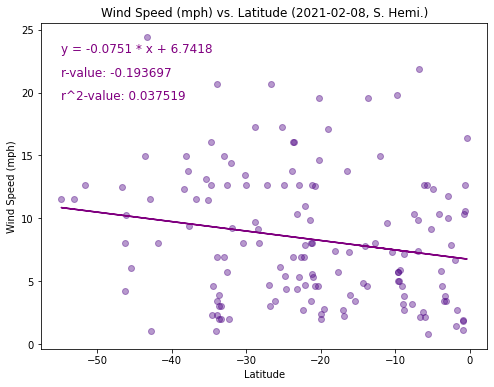

In [19]:
x_values = south_df["Latitude"]
y_str = "Wind Speed (mph)"
y_values = south_df[y_str]

plt.figure(figsize=(8,6))
plt.scatter(x_values, y_values,alpha=0.4,c="indigo")
plt.title(f'{y_str} vs. Latitude ({retrieval_date}, S. Hemi.)')
plt.xlabel("Latitude")
plt.ylabel(y_str)

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = slope * x_values + intercept
plt.plot(x_values, regress_values,color="purple")

x = min(x_values)
y_range = (max(y_values)- min(y_values))

plt.text(x,max(y_values)-y_range*.05,f"y = {round(slope,4)} * x + {round(intercept,4)}",c="purple",size=12)
plt.text(x,max(y_values)-y_range*.13,f"r-value: {round(rvalue,6)}",c="purple",size=12)
plt.text(x,max(y_values)-y_range*.21,f"r^2-value: {round(rvalue**2,6)}",c="purple",size=12)

plt.savefig("output_data/Wind_Speed_vs_Latitude_South.png")
plt.show()

These charts may have the weakest correlation of all, indicating no relevant relationship between latitude and wind speed according to our sample data.

## Final Discussion

Our hypothesis was that temperature depends on latitude, and based on the four weather-phenomena we looked at, only temperature was partially or strongly correlated with latitude in our linear regression models. The other three phenomena (humidity, cloudiness, and wind speed) had much lower r-values, indicating that we cannot draw the same conclusion about a relationship to latitude.

This intuitively makes sense based on what we know about weather, migration, and climate, but looking at this data helps us make a stronger claim and help account for variability of experience globally.

 

Our approach did have several limitations, however:

(1) We used a uniformly random distribution of latitude/longitude coordinates but then mapped them using citypy to the nearest city. I am not entirely sure how that algorithm is constructed, but since most of the globe is covered by ocean, we may be biased toward selecting coastal cities as a result. Weather phenomena may be very different on the coast than on the mainland.

(2) We also did not use the original coordinates generated randomly to ultimately locate a city's weather data (unless that city had a unique name or happened to be the one located by the OpenWeather API). A city with an extremely common name might be found several times by citypy, but because we only passed the name of the city into OpenWeather's query, we may have found a city on an entirely different continent than the one that citypy found.

(3) By limiting our sample weather data to current weather data (as opposed to trends over time), we may be seeing seasonal bias or extremes due to chaotic weather (storms, polar vortices, etc.)

(4) In an era of increasing focus on the global climate change, there may be many factors other than simply latitude that are affecting our weather data that we did not account for, but potentially could explore (e.g. CO2 or Ozone levels in the atmosphere, chemical/industrial elements in the environment, air quality, etc.)

(5) Our approach used the "max temperature" feature of the OpenWeather API, which finds the maximum temperature value in a city if there are multiple measurements from that city (it would likely be a large city). Also, utilizing data from cities, especially large urban centers, may be biased (up to 1.8–5.4 degrees hotter) due to the "Urban Heat Island" phenomenon (see below).

Urban Heat Island:

https://www.nationalgeographic.org/encyclopedia/urban-heat-island/#:~:text=According%20to%20the%20Environmental%20Protection,Celsius%20warmer%20than%20its%20surroundings.&text=Powered%20by-,An%20urban%20heat%20island%2C%20or%20UHI%2C%20is%20a%20metropolitan%20area,the%20rural%20areas%20surrounding%20it.